# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,no-author-rec,6875,8759
1,BX-E,no-book,21884,25524
2,BX-E,female,38089,138864
3,BX-E,ambiguous,4209,31171
4,BX-E,unknown,17003,27577


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ14,217032.0,490953.0,17781.0,239324.0,141112.0,151529.0,1010096.0,2267827.0
AZ18,257434.0,568752.0,19701.0,280442.0,165917.0,243582.0,1331737.0,2867565.0
BX-E,38089.0,56454.0,4209.0,17003.0,6875.0,6548.0,21884.0,151062.0
BX-I,67153.0,98053.0,7141.0,34792.0,14003.0,13047.0,44068.0,278257.0
GR-E,175748.0,279466.0,11649.0,96499.0,30123.0,894574.0,NaN,1488059.0
GR-I,177359.0,282857.0,11756.0,98268.0,30837.0,908584.0,NaN,1509661.0
LOC-MDS,666636.0,2212573.0,54205.0,1219145.0,272587.0,842797.0,NaN,5267943.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,4320053.0,6598367.0,552578.0,2082393.0,732627.0,2076437.0,6096946.0
AZ18,9518581.0,13527898.0,1100481.0,3940837.0,1577619.0,6588512.0,14615317.0
BX-E,138864.0,185762.0,31171.0,27577.0,8759.0,9505.0,25524.0
BX-I,391574.0,469654.0,78178.0,78104.0,23301.0,25905.0,62530.0
GR-E,34919361.0,35174478.0,8874836.0,3978466.0,531128.0,16923705.0,NaN
GR-I,76649642.0,71778599.0,14398601.0,10519906.0,1499773.0,46650160.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,0.095700,0.216486,0.007841,0.105530,0.062223,0.066817,0.445403
AZ18,0.089774,0.198340,0.006870,0.097798,0.057860,0.084944,0.464414
BX-E,0.252142,0.373714,0.027863,0.112556,0.045511,0.043346,0.144868
BX-I,0.241334,0.352383,0.025663,0.125035,0.050324,0.046888,0.158372
GR-E,0.118106,0.187806,0.007828,0.064849,0.020243,0.601168,NaN
GR-I,0.117483,0.187365,0.007787,0.065093,0.020426,0.601846,NaN
LOC-MDS,0.126546,0.420007,0.010290,0.231427,0.051744,0.159986,NaN


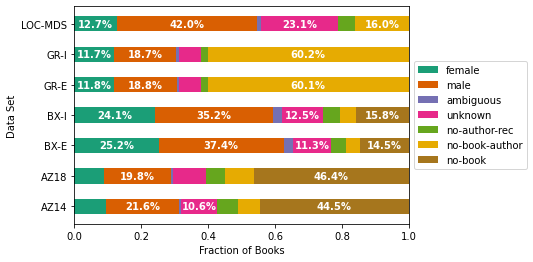

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ14,0.095700,0.216486,0.007841,0.105530,0.574443
AZ18,0.089774,0.198340,0.006870,0.097798,0.607218
BX-E,0.252142,0.373714,0.027863,0.112556,0.233725
BX-I,0.241334,0.352383,0.025663,0.125035,0.255584
GR-E,0.118106,0.187806,0.007828,0.064849,0.621412
GR-I,0.117483,0.187365,0.007787,0.065093,0.622273
LOC-MDS,0.126546,0.420007,0.010290,0.231427,0.211730


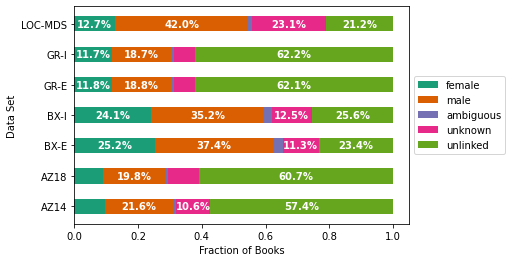

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

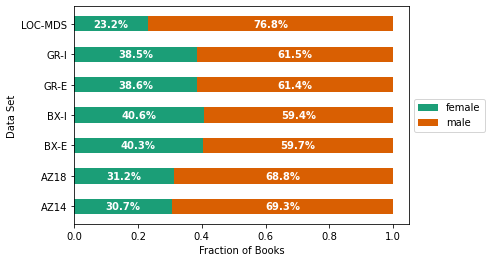

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,0.192349,0.293791,0.024603,0.092718,0.032620,0.092453,0.271465
AZ18,0.187119,0.265935,0.021634,0.077470,0.031013,0.129519,0.287311
BX-E,0.325085,0.434875,0.072972,0.064559,0.020505,0.022252,0.059753
BX-I,0.346757,0.415901,0.069230,0.069165,0.020634,0.022940,0.055373
GR-E,0.347796,0.350337,0.088393,0.039625,0.005290,0.168559,NaN
GR-I,0.346053,0.324062,0.065006,0.047495,0.006771,0.210613,NaN


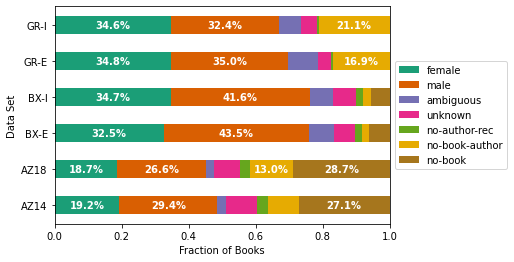

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ14,0.192349,0.293791,0.024603,0.092718,0.396538
AZ18,0.187119,0.265935,0.021634,0.077470,0.447843
BX-E,0.325085,0.434875,0.072972,0.064559,0.102509
BX-I,0.346757,0.415901,0.069230,0.069165,0.098947
GR-E,0.347796,0.350337,0.088393,0.039625,0.173850
GR-I,0.346053,0.324062,0.065006,0.047495,0.217384


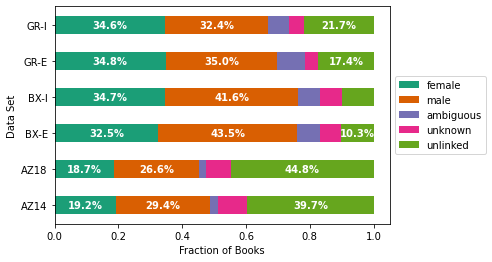

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

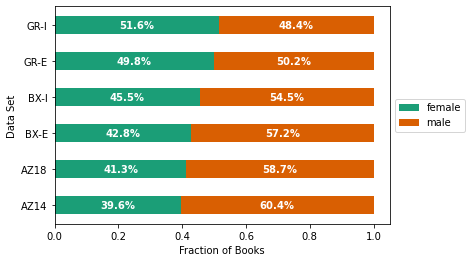

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.

In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ14       0.320027
AZ18       0.294984
BX-E       0.653718
BX-I       0.619381
GR-E       0.313740
GR-I       0.312634
LOC-MDS    0.556842
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')